In [ ]:
import numpy as np
import pandas as pd
from google.oauth2 import service_account
from apiclient.discovery import build

In [ ]:
def format_summary(response):
    try:
        # create row index
        try: 
            row_index_names = response['reports'][0]['columnHeader']['dimensions']
            row_index = [ element['dimensions'] for element in response['reports'][0]['data']['rows'] ]
            row_index_named = pd.MultiIndex.from_arrays(np.transpose(np.array(row_index)), 
                                                        names = np.array(row_index_names))
        except:
            row_index_named = None
        
        # extract column names
        summary_column_names = [item['name'] for item in response['reports'][0]
                                ['columnHeader']['metricHeader']['metricHeaderEntries']]
    
        # extract table values
        summary_values = [element['metrics'][0]['values'] for element in response['reports'][0]['data']['rows']]
    
        # combine. I used type 'float' because default is object, and as far as I know, all values are numeric
        df = pd.DataFrame(data = np.array(summary_values), 
                          index = row_index_named, 
                          columns = summary_column_names).astype('float')
    
    except:
        df = pd.DataFrame()
        
    return df

def format_pivot(response):
    try:
        # extract table values
        pivot_values = [item['metrics'][0]['pivotValueRegions'][0]['values'] for item in response['reports'][0]
                        ['data']['rows']]
        
        # create column index
        top_header = [item['dimensionValues'] for item in response['reports'][0]
                      ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
        column_metrics = [item['metric']['name'] for item in response['reports'][0]
                          ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
        array = np.concatenate((np.array(top_header),
                                np.array(column_metrics).reshape((len(column_metrics),1))), 
                               axis = 1)
        column_index = pd.MultiIndex.from_arrays(np.transpose(array))
        
        # create row index
        try:
            row_index_names = response['reports'][0]['columnHeader']['dimensions']
            row_index = [ element['dimensions'] for element in response['reports'][0]['data']['rows'] ]
            row_index_named = pd.MultiIndex.from_arrays(np.transpose(np.array(row_index)), 
                                                        names = np.array(row_index_names))
        except: 
            row_index_named = None
        # combine into a dataframe
        df = pd.DataFrame(data = np.array(pivot_values), 
                          index = row_index_named, 
                          columns = column_index).astype('float')
    except:
        df = pd.DataFrame()
    return df

def format_report(response):
    summary = format_summary(response)
    pivot = format_pivot(response)
    if pivot.columns.nlevels == 2:
        summary.columns = [['']*len(summary.columns), summary.columns]
    
    return(pd.concat([summary, pivot], axis = 1))

def run_report(body, credentials_file):
    #Create service credentials
    credentials = service_account.Credentials.from_service_account_file(credentials_file, 
                                scopes = ['https://www.googleapis.com/auth/analytics.readonly'])
    #Create a service object
    service = build('analyticsreporting', 'v4', credentials=credentials)
    
    #Get GA data
    response = service.reports().batchGet(body=body).execute()
    print(response)
    return(format_report(response))

In [ ]:
your_view_id = '251459580'
ga_keys = '/content/prefab-atlas-265816-69ad0055ac48.json'

In [ ]:
body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2019-01-01', 'endDate': '2021-09-30'}],
                            'metrics': [{'expression': 'ga:users'}, 
                                        {"expression": "ga:bounceRate"}],
                            'dimensions': [{'name': 'ga:yearMonth'}],
                            "pivots": [{"dimensions": [{"name": "ga:channelGrouping"}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:bounceRate"}]
                                       }]
                          }]}

In [ ]:
summary_body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-02-28'}],
                            'metrics': [{'expression': 'ga:sessions'}, 
                                        {'expression': 'ga:totalEvents'}, 
                                        {"expression": "ga:avgSessionDuration"}],
                            'dimensions': [{'name': 'ga:country'}],
                          }]}

In [ ]:
pivot_body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-02-28'}],
                            'dimensions': [{'name':  "ga:channelGrouping"}],
                            "pivots": [{"dimensions": [{"name": 'ga:yearMonth'}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:newUsers"},
                                                    {"expression": "ga:timeOnPage"}]
                                       }]
                          }]}

In [ ]:
short_body = {  "reportRequests":
  [{
      "viewId": your_view_id,
      "dateRanges": [{"startDate": "7daysAgo", "endDate": "yesterday"}],
      "metrics": [{"expression": "ga:users"}]
    }]}

In [ ]:
untidy_body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-02-28'}],
                            "pivots": [{"dimensions": [{"name": 'ga:yearMonth'}, {"name": "ga:channelGrouping"}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:timeOnPage"}]
                                       }]
                          }]}

In [ ]:
ga_report = run_report(body, ga_keys)
ga_report

Direct               Referral  \
             ga:users ga:bounceRate ga:users ga:bounceRate ga:users   
ga:yearMonth                                                          
202109            4.0          40.0      3.0          60.0      1.0   

                            
             ga:bounceRate  
ga:yearMonth                
202109                30.0

In [ ]:
credentials = service_account.Credentials.from_service_account_file(ga_keys, 
                                scopes = ['https://www.googleapis.com/auth/analytics.readonly'])
    #Create a service object
service = build('analyticsreporting', 'v4', credentials=credentials)
    
    #Get GA data
response = service.reports().batchGet(body=body).execute()
response

{'reports': [{'columnHeader': {'dimensions': ['ga:yearMonth'],
    'metricHeader': {'metricHeaderEntries': [{'name': 'ga:users',
       'type': 'INTEGER'},
      {'name': 'ga:bounceRate', 'type': 'PERCENT'}],
     'pivotHeaders': [{'pivotHeaderEntries': [{'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Direct'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Direct'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Referral'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Referral'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}}],
       'totalPivotGroupsCount': 2}]}},
   'data': {'isDataGolden': True,
    'maximums': [{'pivotValueRegions': [{'values': ['3',


In [ ]:
format_pivot(response)

Direct               Referral              
             ga:users ga:bounceRate ga:users ga:bounceRate
ga:yearMonth                                              
202109            3.0          60.0      1.0          30.0

In [ ]:
top_header = [item['dimensionValues'] for item in response['reports'][0]
                      ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
column_metrics = [item['metric']['name'] for item in response['reports'][0]
                          ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
array = np.concatenate((np.array(top_header),
                        np.array(column_metrics).reshape((len(column_metrics),1))),
                       axis = 1)

column_index = pd.MultiIndex.from_arrays(np.transpose(array))
column_index

MultiIndex([(  'Direct',      'ga:users'),
            (  'Direct', 'ga:bounceRate'),
            ('Referral',      'ga:users'),
            ('Referral', 'ga:bounceRate')],
           )

In [ ]:
response['reports'][0]['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']


[{'dimensionNames': ['ga:channelGrouping'],
  'dimensionValues': ['Direct'],
  'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
 {'dimensionNames': ['ga:channelGrouping'],
  'dimensionValues': ['Direct'],
  'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}},
 {'dimensionNames': ['ga:channelGrouping'],
  'dimensionValues': ['Referral'],
  'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
 {'dimensionNames': ['ga:channelGrouping'],
  'dimensionValues': ['Referral'],
  'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}}]

In [ ]:
[item.get('dimensionValues') for item in response['reports'][0]['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]

[['Direct'], ['Direct'], ['Referral'], ['Referral']]

In [ ]:
report = run_report(body, ga_keys)
report

Direct               Referral  \
             ga:users ga:bounceRate ga:users ga:bounceRate ga:users   
ga:yearMonth                                                          
202109            4.0          40.0      3.0          60.0      1.0   

                            
             ga:bounceRate  
ga:yearMonth                
202109                30.0

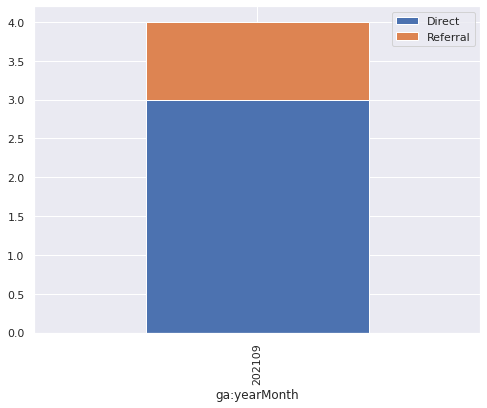

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# set seaborn style
sns.set_theme()
sns.set(rc={'figure.figsize':(8,6)})

plot_data = report.loc[:, (slice(None), "ga:users")].iloc[:, 1:] # Pick users columns, drop the first one (sum)
plot_data.columns = plot_data.columns.get_level_values(0)
plot_data.index = plot_data.index.get_level_values(0)
plot_data.plot.bar(stacked = True);

In [ ]:
body = body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2019-01-01', 'endDate': '2021-10-30'}],
                            'metrics': [{'expression': 'ga:sessions'},
                                        {"expression": "ga:avgSessionDuration"},
                                        {"expression": "ga:users"},
                                        {"expression": "ga:newUsers"}],
                            'dimensions': [{'name': 'ga:date'},
                                           {"name": "ga:channelGrouping"}],
                          }]}

report = run_report(body, ga_keys).reset_index() # index is turned into columns to help with visualization
report

,ga:date,ga:channelGrouping,ga:sessions,ga:avgSessionDuration,ga:users,ga:newUsers
0,20210919,Direct,4.0,28.250000,2.0,2.0
1,20210919,Referral,2.0,1120.000000,1.0,1.0
2,20210920,Direct,1.0,0.000000,1.0,1.0
3,20210921,Referral,1.0,0.000000,1.0,0.0
4,20210924,Referral,3.0,627.333333,1.0,0.0
5,20210925,Referral,2.0,2920.000000,1.0,0.0
6,20210929,Referral,1.0,1146.000000,1.0,0.0
7,20210930,Referral,1.0,0.000000,1.0,0.0


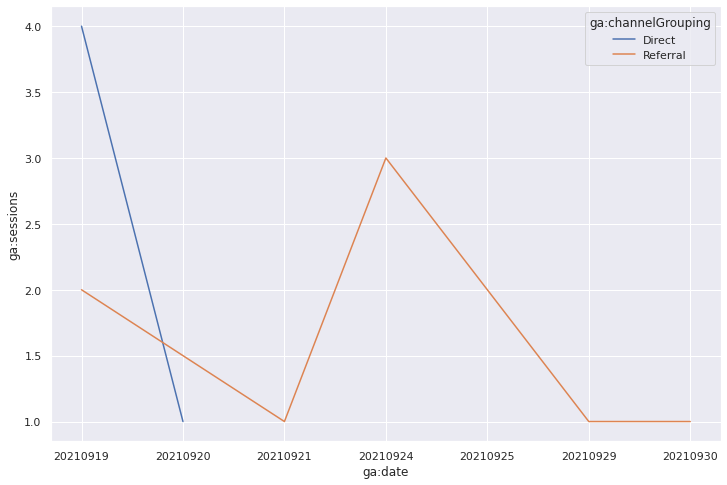

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
plot_data = report.loc[:, ["ga:users"]]
sns.lineplot(data = report, y = "ga:sessions", x = 'ga:date', hue = 'ga:channelGrouping');